In [ ]:
"""
Notebook for training the transformer model for the Lorenz system.
=====
Distributed by: Notre Dame SCAI Lab (MIT Liscense)
- Associated publication:
url: https://arxiv.org/abs/2010.03957
doi: 
github: https://github.com/zabaras/transformer-physx
=====
"""
!nvidia-smi

Thu Jul  8 18:03:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Environment Setup

In [ ]:
!pip install torch==1.8.1
!pip install h5py==2.10.0
!pip install filelock==3.0.12
!pip install scipy==1.6.3
!pip install matplotlib==3.4.2

First mount google drive and clone transformer physx repo.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [ ]:
!git clone https://github.com/zabaras/transformer-physx.git
%cd ./transformer-physx/examples/lorenz/

fatal: destination path 'transformer-physx' already exists and is not an empty directory.
/content/gdrive/My Drive/transformer-physx/examples/lorenz


## Downloading Data and Models

Now lets download the training and validation data for the lorenz system. Info on wget from [Google drive](https://stackoverflow.com/questions/37453841/download-a-file-from-google-drive-using-wget). This will eventually be update to zenodo repo.

In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
!wget -O ./data/lorenz_training_rk.hdf5 "https://drive.google.com/uc?export=download&id=1vGTGzaqEZxxuLN9K-PUrYw9SLWttdDYd"
!wget -O ./data/lorenz_valid_rk.hdf5 "https://drive.google.com/uc?export=download&id=1bxFzKg8tSagE8kXWGm2mtaJ4gPsKJ8sI"

--2021-07-08 18:09:10--  https://drive.google.com/uc?export=download&id=1vGTGzaqEZxxuLN9K-PUrYw9SLWttdDYd
Resolving drive.google.com (drive.google.com)... 142.250.141.138, 142.250.141.113, 142.250.141.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3r1jnrc66c3kti72pghk2mq9odmrag06/1625767725000/01559412990587423567/*/1vGTGzaqEZxxuLN9K-PUrYw9SLWttdDYd?e=download [following]
--2021-07-08 18:09:11--  https://doc-0o-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3r1jnrc66c3kti72pghk2mq9odmrag06/1625767725000/01559412990587423567/*/1vGTGzaqEZxxuLN9K-PUrYw9SLWttdDYd?e=download
Resolving doc-0o-0o-docs.googleusercontent.com (doc-0o-0o-docs.googleusercontent.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to doc-0o-0o-docs.googleusercontent.com (doc

Next lets download a pretrained embedding model. You can replace with with your own if you want.

In [ ]:
!wget -O ./embedding_lorenz300.pth "https://drive.google.com/uc?export=download&id=1NWm4j55Yv6miQH3oRj0119HpudvbfVpo"

--2021-07-08 18:09:17--  https://drive.google.com/uc?export=download&id=1NWm4j55Yv6miQH3oRj0119HpudvbfVpo
Resolving drive.google.com (drive.google.com)... 142.250.141.102, 142.250.141.139, 142.250.141.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h8gn70onoudhfcj1ivp0enmqdgme45be/1625767725000/01559412990587423567/*/1NWm4j55Yv6miQH3oRj0119HpudvbfVpo?e=download [following]
--2021-07-08 18:09:17--  https://doc-00-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h8gn70onoudhfcj1ivp0enmqdgme45be/1625767725000/01559412990587423567/*/1NWm4j55Yv6miQH3oRj0119HpudvbfVpo?e=download
Resolving doc-00-0o-docs.googleusercontent.com (doc-00-0o-docs.googleusercontent.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to doc-00-0o-docs.googleusercontent.com (doc

# Transformer-PhysX Lorenz System

Now lets actually run some Python, set up imports. Note that since the Lorenz system is built into transformer-physx package we will use auto modules to load the specific classes for this numerical example.

In [ ]:
import sys
sys.path.append('../..')
import logging
import torch
from trphysx.config import HfArgumentParser
from trphysx.config.args import ModelArguments, TrainingArguments, DataArguments, ArgUtils
from trphysx.config import AutoPhysConfig
from trphysx.transformer import PhysformerTrain, PhysformerGPT2
from trphysx.embedding import AutoEmbeddingModel
from trphysx.viz import AutoViz
from trphysx.data_utils import AutoDataset
from trphysx.utils.trainer import Trainer

logger = logging.getLogger(__name__)

Set training arguments. For running this outside of a notebook, you would use "sys.argv" and then no arguement when you parse args into dataclasses. This would allow the use of command line parameters as well. See [example script](https://github.com/zabaras/transformer-physx/blob/main/examples/lorenz/train_lorenz.py) on the github repo.

In [ ]:
argv = []
argv = argv + ["--init_name", "lorenz"]
argv = argv + ["--embedding_file_or_path", "./embedding_lorenz300.pth"]
argv = argv + ["--training_h5_file","./data/lorenz_training_rk.hdf5"]
argv = argv + ["--eval_h5_file","./data/lorenz_valid_rk.hdf5"]
argv = argv + ["--train_batch_size", "32"]
argv = argv + ["--stride", "64"]
argv = argv + ["--n_train", "2048"]
argv = argv + ["--save_steps", "10"]
argv = argv + ["--n_eval", "16"]

In [ ]:
# Parse arguments using the hugging face argument parser
parser = HfArgumentParser((ModelArguments, DataArguments, TrainingArguments))
model_args, data_args, training_args = parser.parse_args_into_dataclasses(argv)

# Setup logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO if training_args.local_rank in [-1, 0] else logging.WARN)
# Configure arguments after intialization 
model_args, data_args, training_args = ArgUtils.config(model_args, data_args, training_args)

# Load model configuration
config = AutoPhysConfig.load_config(model_args.config_name)

07/08/2021 18:14:04 - INFO - root -   Using a single GPU for training.


{'n_ctx': 64, 'n_embd': 32, 'n_layer': 4, 'n_head': 4, 'state_dims': [3], 'activation_function': 'gelu_new', 'initializer_range': 0.05}


## Initalizing Models

In [ ]:
# Load embedding model
embedding_model = AutoEmbeddingModel.load_model(
    model_args.embedding_name, 
    config, 
    model_args.embedding_file_or_path).to(training_args.src_device)

# Load visualization utility class
viz = AutoViz.init_viz(model_args.viz_name)(training_args.plot_dir)

# Init transformer model
transformer = PhysformerGPT2(config, model_args.model_name)
model  = PhysformerTrain(config, transformer)
if(training_args.epoch_start > 0):
    model.load_model(training_args.ckpt_dir, epoch=training_args.epoch_start)
if(model_args.transformer_file_or_path):
    model.load_model(model_args.transformer_file_or_path)

07/08/2021 18:14:06 - INFO - trphysx.embedding.embedding_lorenz -   Number of embedding parameters: 36192
07/08/2021 18:14:06 - INFO - trphysx.embedding.embedding_model -   Loading embedding model from file: ./embedding_lorenz300.pth
07/08/2021 18:14:09 - INFO - trphysx.transformer.phys_transformer_gpt2 -   Number of parameters: 53984


## Creating Datasets

Next create the training and validation datasets. This will probably take a little bit. We need to compute the embedded representations for the transformer for each example. Forcunately, assuming your embedding model has not changed or block size, the dataset will be locally cached allowing for fast reloading in the future. Use the "overwrite_cache" argument to force a new dataset creation.

In [ ]:
# Initialize training and validation datasets
training_data = AutoDataset.create_dataset(
      model_args.model_name,
      embedding_model, 
      data_args.training_h5_file, 
      block_size=config.n_ctx, 
      stride=data_args.stride,
      ndata=data_args.n_train, 
      overwrite_cache=data_args.overwrite_cache)

eval_data = AutoDataset.create_dataset(
      model_args.model_name,
      embedding_model, 
      data_args.eval_h5_file, 
      block_size=256,
      stride=1024,
      ndata=data_args.n_eval, 
      eval = True,
      overwrite_cache=data_args.overwrite_cache)

07/08/2021 18:14:16 - INFO - filelock -   Lock 140693458414864 acquired on ./data/cached2048_LorenzEmbedding_64_lorenz_training_rk.hdf5.lock
07/08/2021 18:14:17 - INFO - trphysx.data_utils.dataset_phys -   Loading features from cached file ./data/cached2048_LorenzEmbedding_64_lorenz_training_rk.hdf5 [took 1.404 s]
07/08/2021 18:14:17 - INFO - filelock -   Lock 140693458414864 released on ./data/cached2048_LorenzEmbedding_64_lorenz_training_rk.hdf5.lock
07/08/2021 18:14:17 - INFO - filelock -   Lock 140693493273872 acquired on ./data/cached16_LorenzEmbedding_256_lorenz_valid_rk.hdf5.lock
07/08/2021 18:14:17 - INFO - trphysx.data_utils.dataset_phys -   Loading features from cached file ./data/cached16_LorenzEmbedding_256_lorenz_valid_rk.hdf5 [took 0.008 s]
07/08/2021 18:14:17 - INFO - filelock -   Lock 140693493273872 released on ./data/cached16_LorenzEmbedding_256_lorenz_valid_rk.hdf5.lock


Initialize the optimizer and scheduler.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=training_args.lr, weight_decay=1e-10)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 14, 2, eta_min=1e-9)

## Training the Transformer

Create training class and train.

In [ ]:
trainer = Trainer(
        model, 
        training_args, 
        (optimizer, scheduler), 
        train_dataset = training_data, 
        eval_dataset = eval_data, 
        embedding_model = embedding_model,
        viz=viz)
    
trainer.train()

07/08/2021 18:14:26 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00095
07/08/2021 18:14:26 - INFO - trphysx.utils.trainer -   Epoch 1: Training loss 0.06997
07/08/2021 18:14:26 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00095
07/08/2021 18:14:26 - INFO - trphysx.utils.trainer -   Evaluating...
07/08/2021 18:14:29 - INFO - trphysx.utils.trainer -   Eval embedding error: 0.91, State error: 137.52
07/08/2021 18:14:29 - INFO - trphysx.utils.trainer -   Checkpointing model, optimizer and scheduler.
07/08/2021 18:14:32 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00089
07/08/2021 18:14:32 - INFO - trphysx.utils.trainer -   Epoch 2: Training loss 0.00034
07/08/2021 18:14:36 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00081
07/08/2021 18:14:36 - INFO - trphysx.utils.trainer -   Epoch 3: Training loss 0.00020
07/08/2021 18:14:40 - INFO - trphysx.utils.trainer -   Current Learning rate: 0.00072
07/08/2021 18:14:40 - INFO - trphysx.ut

## Visualization of Results

We will just embed a few of the test prediction for several epochs. More can be viewed in the outputs folder.

Validation prediction for epoch: 1


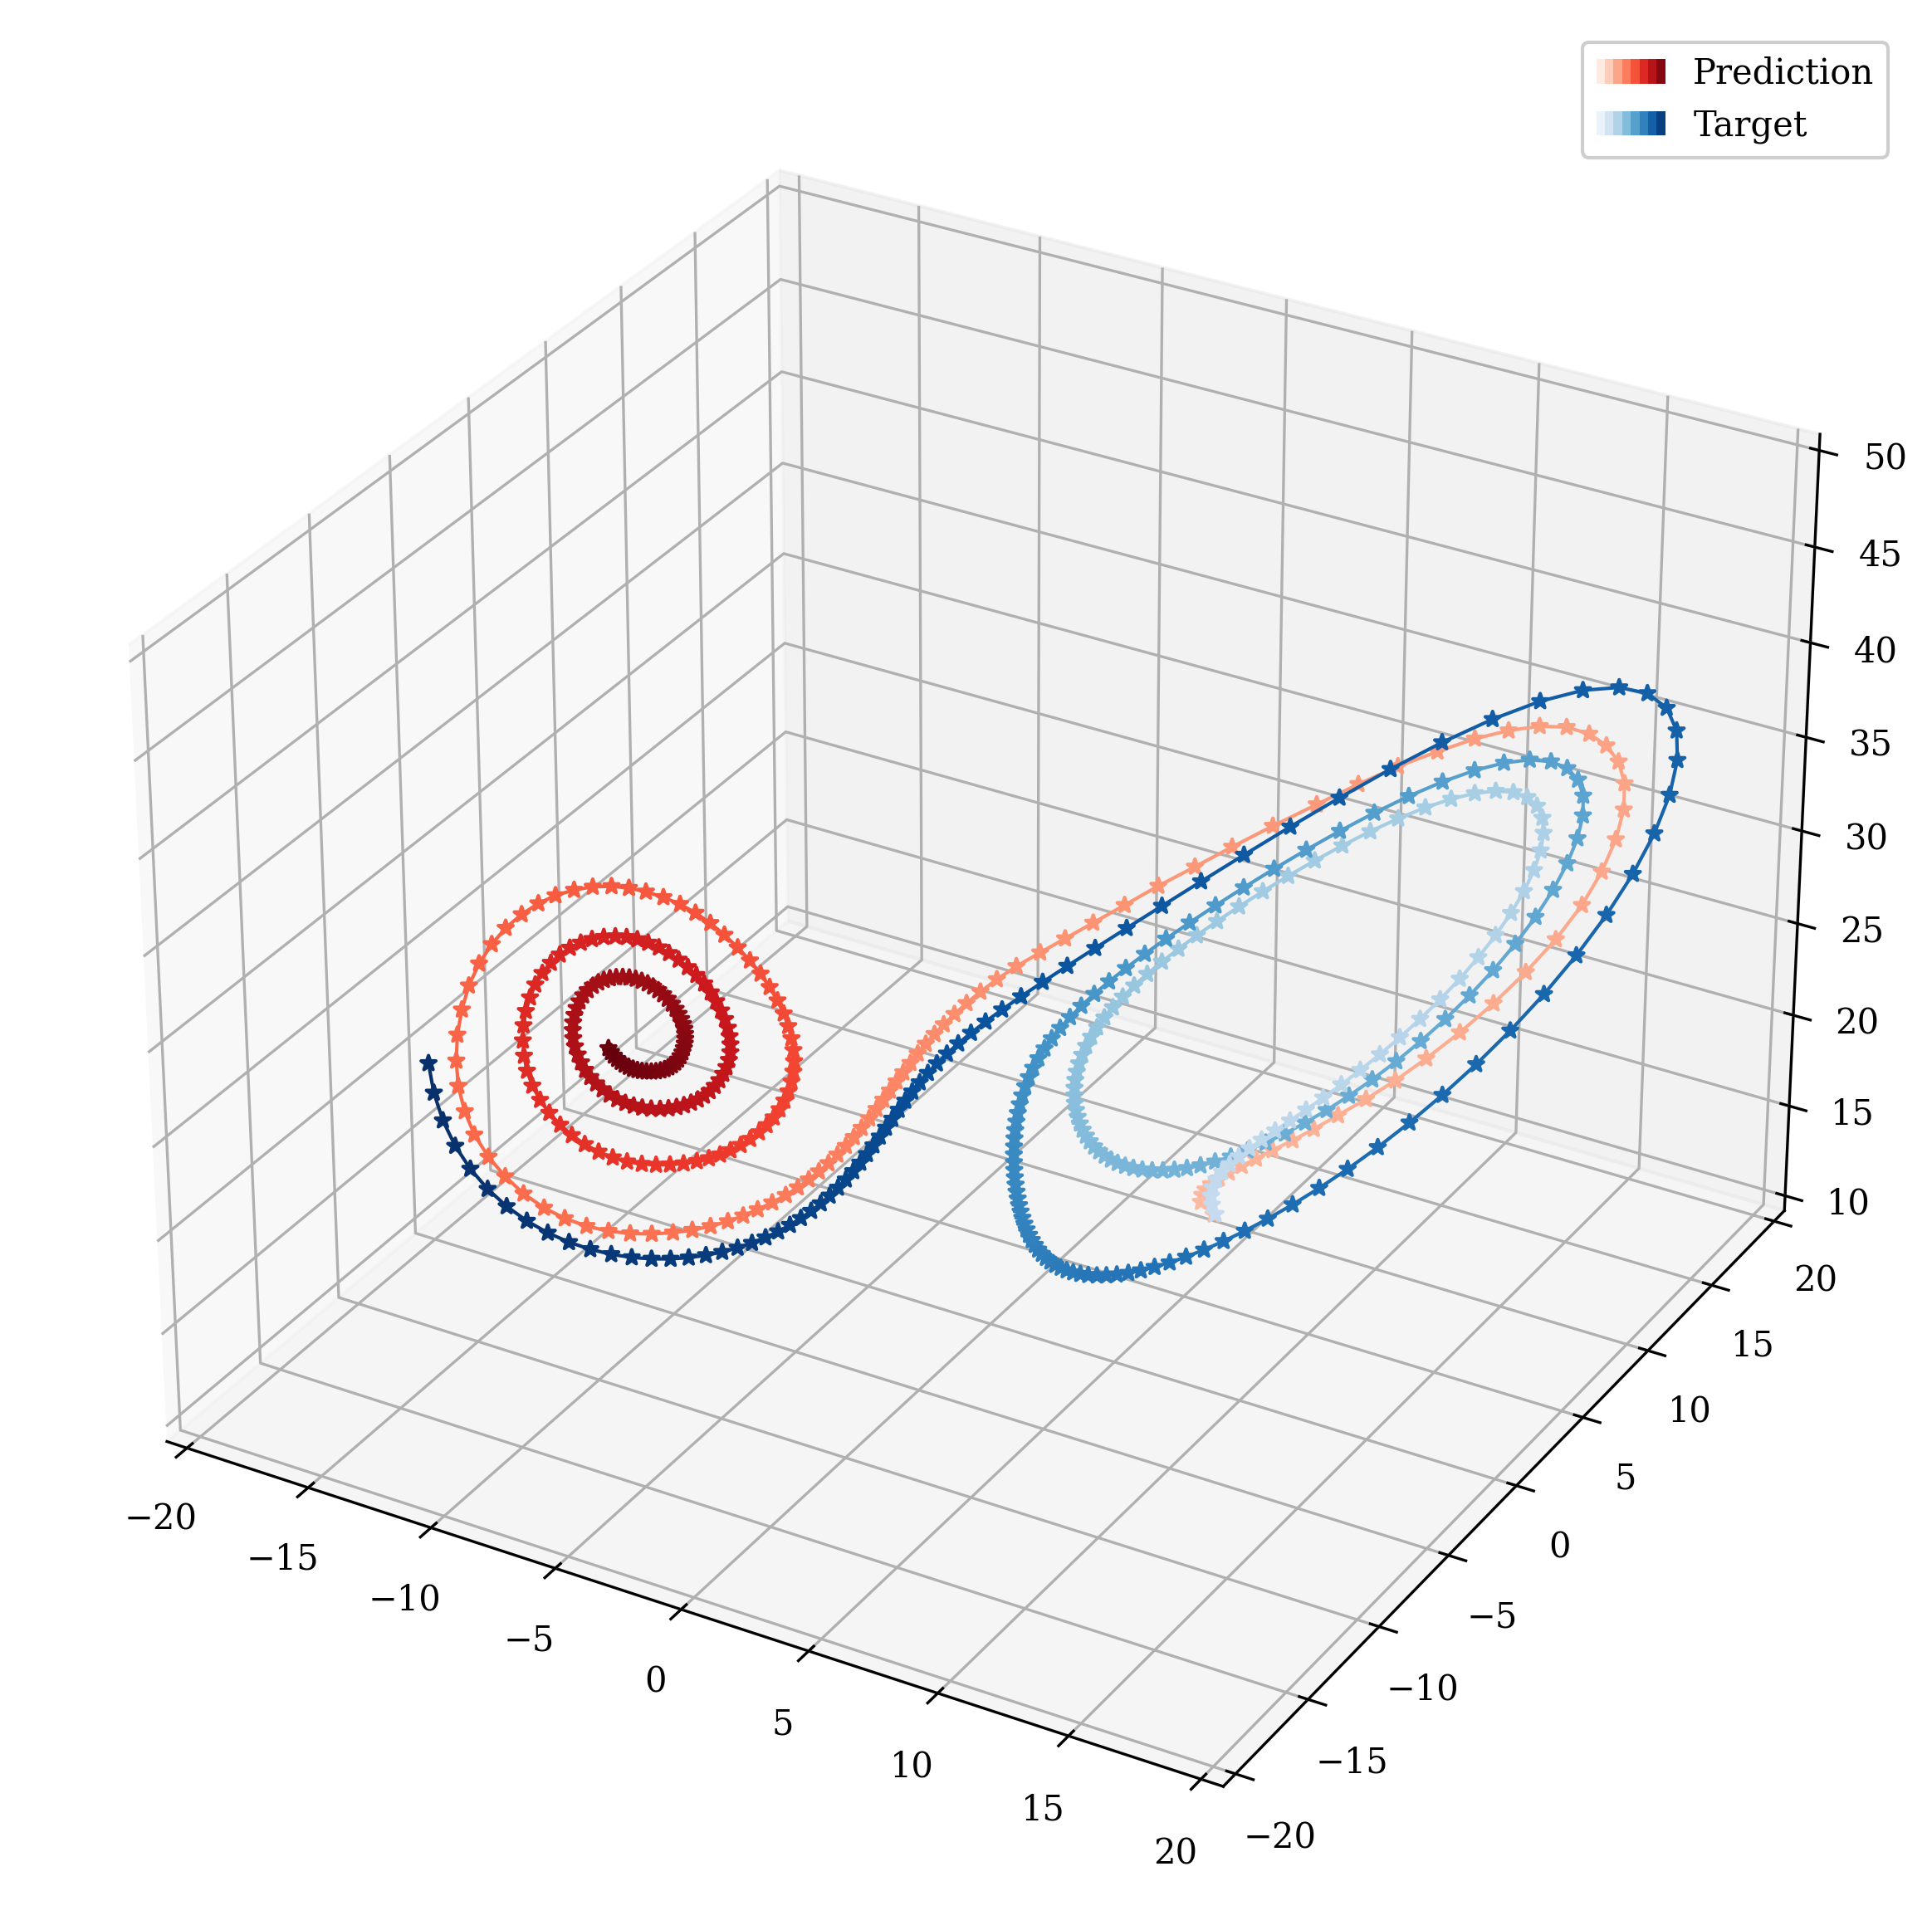

Validation prediction for epoch: 50


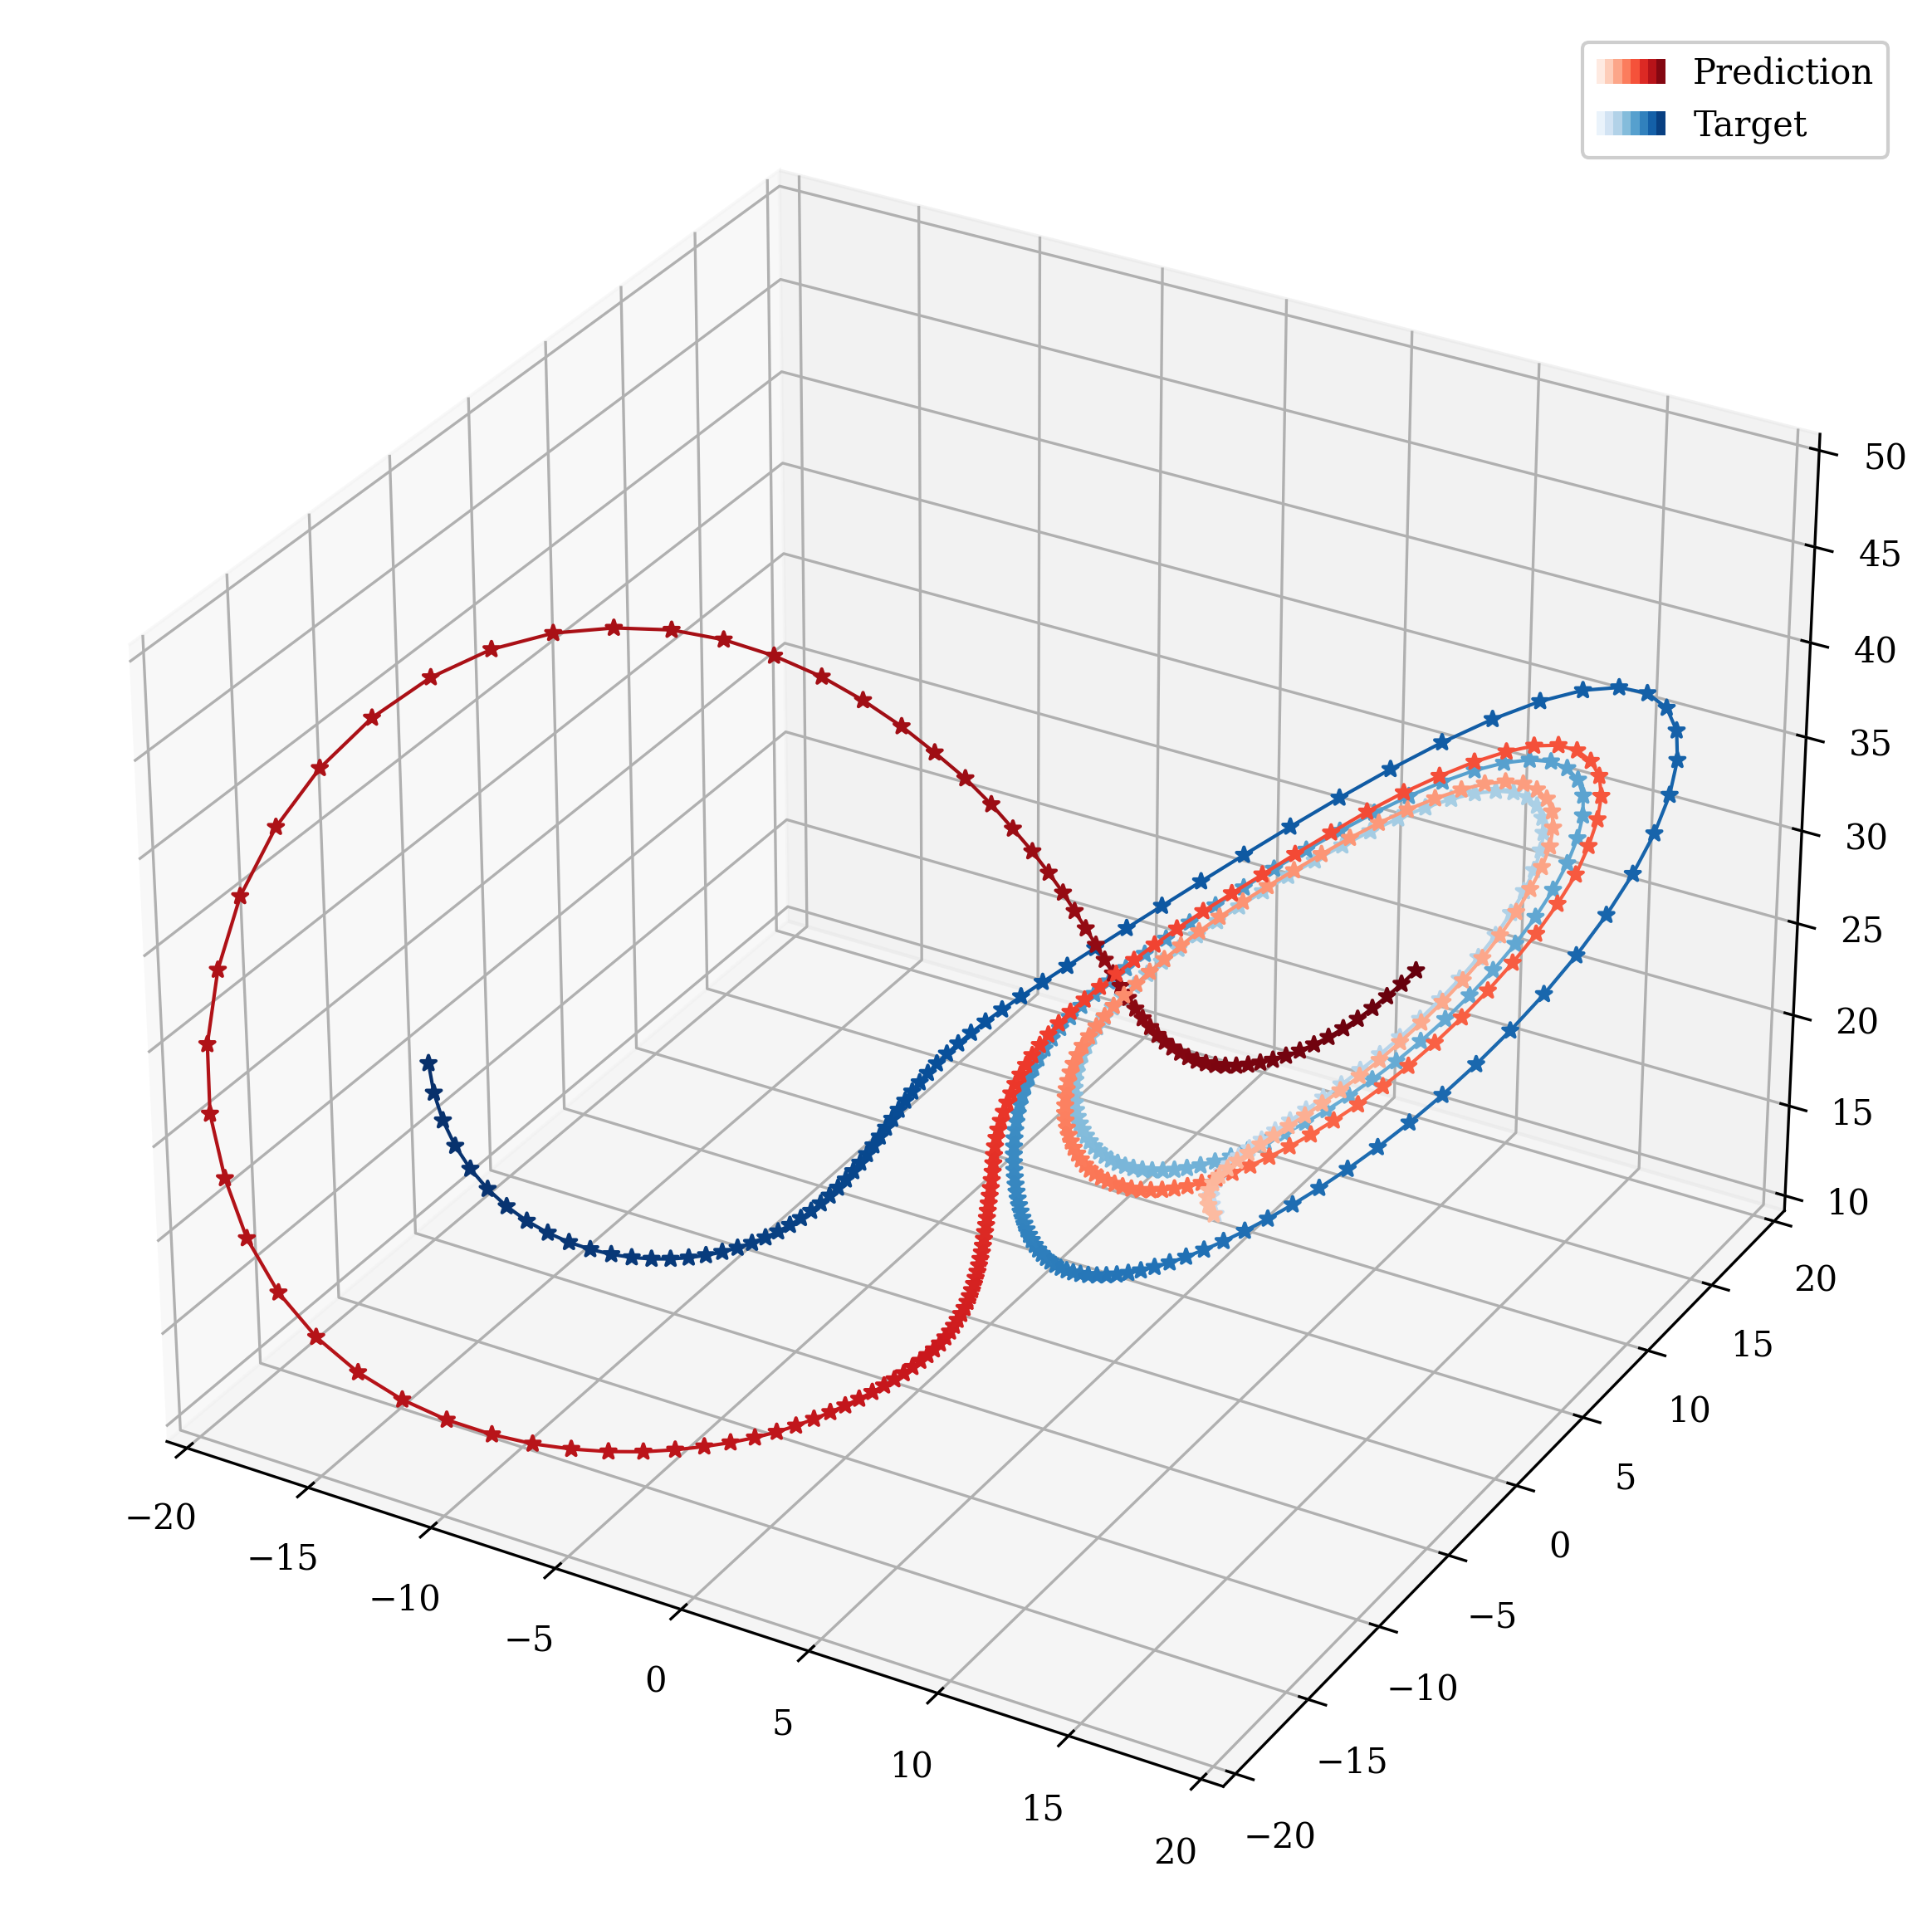

Validation prediction for epoch: 100


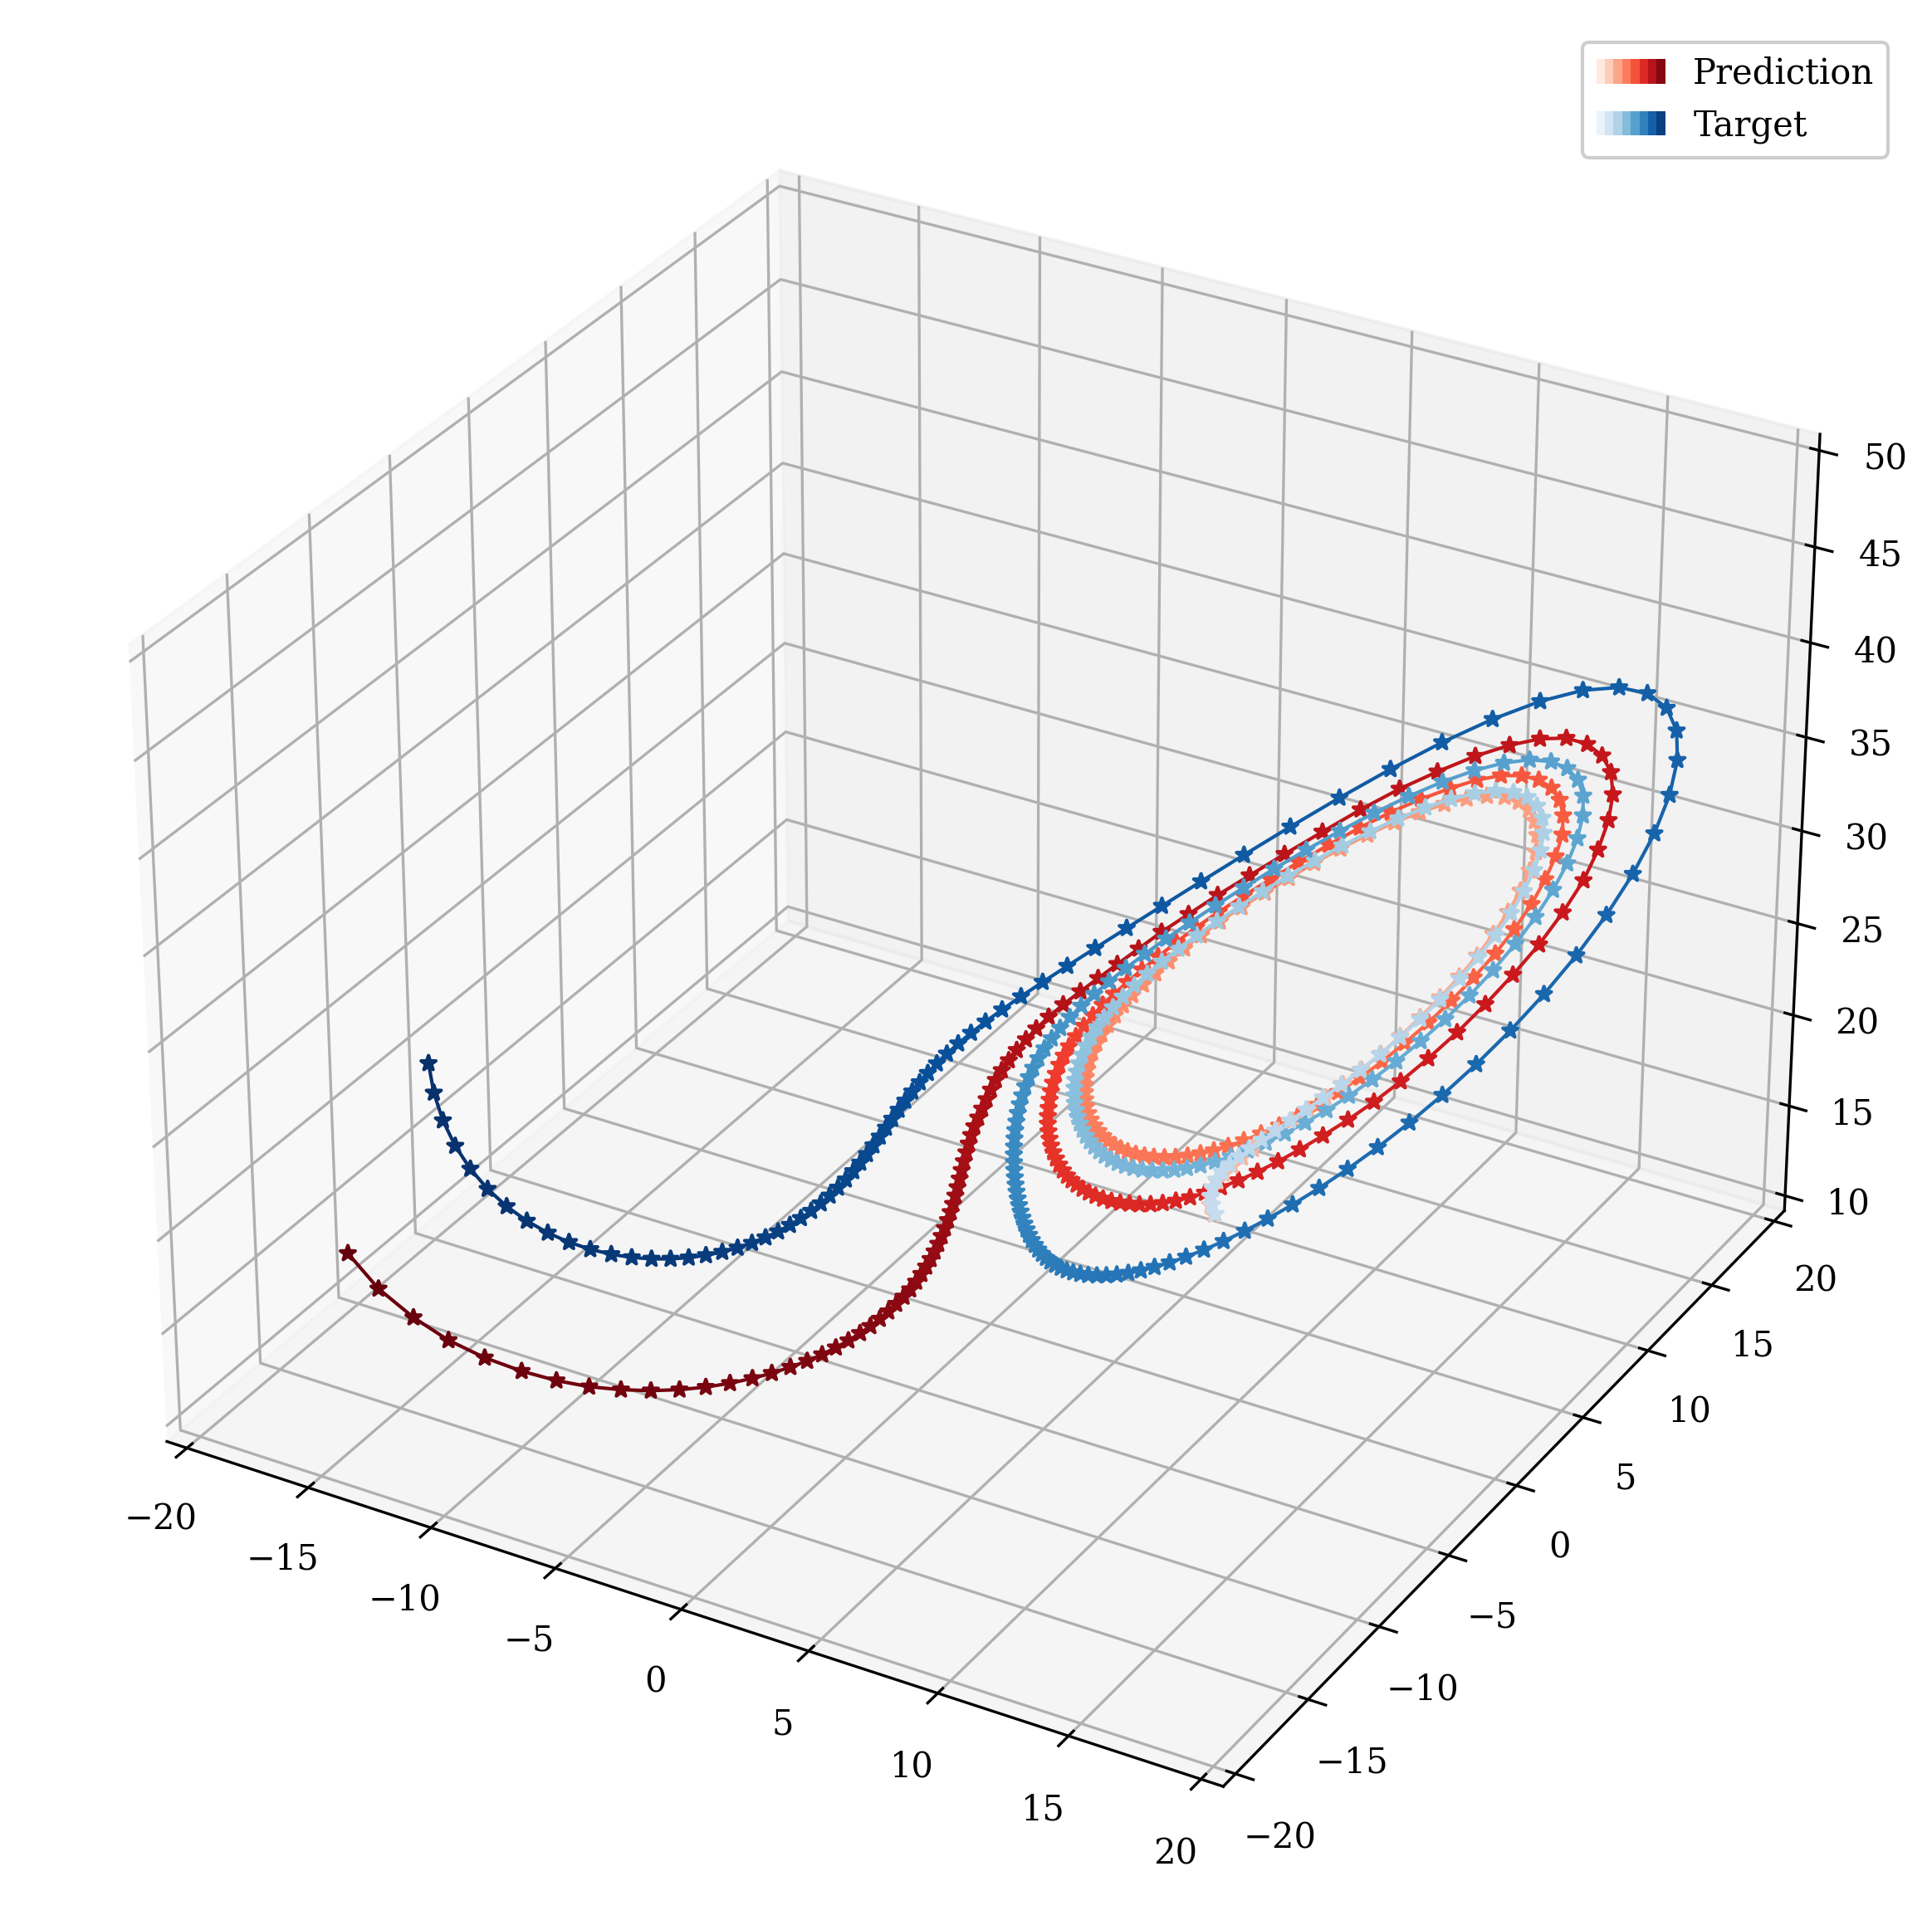

Validation prediction for epoch: 150


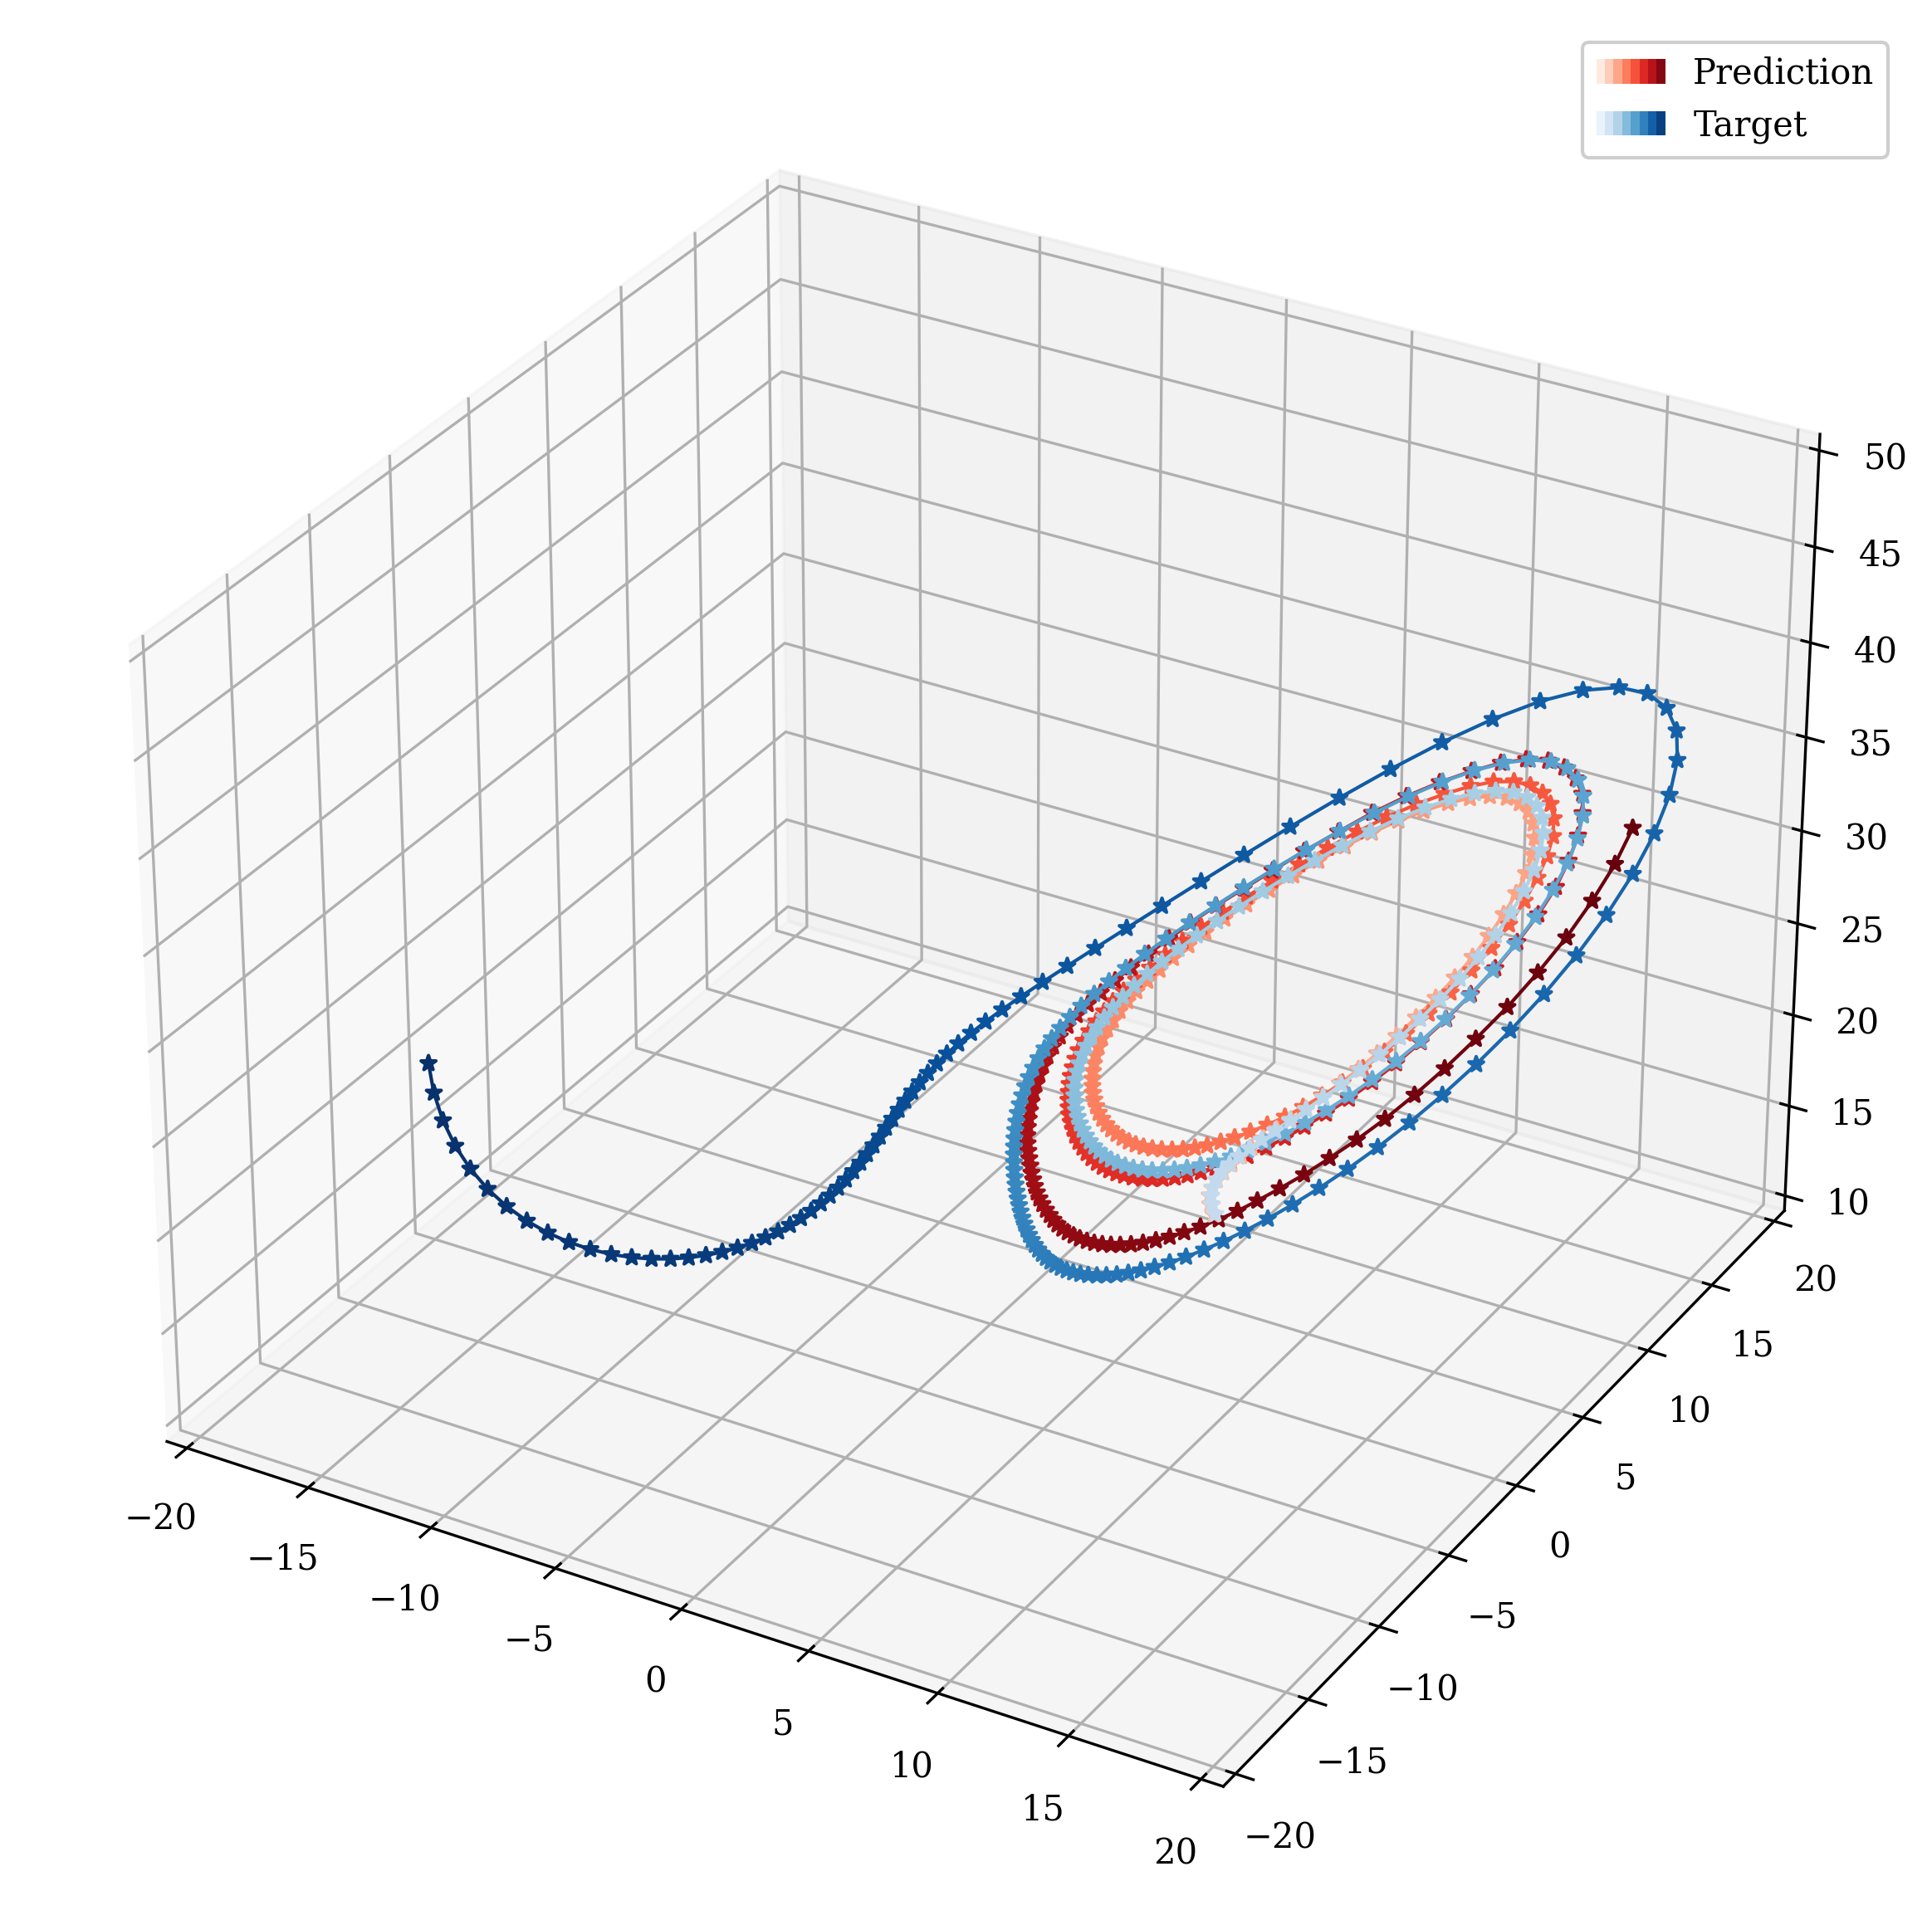

Validation prediction for epoch: 200


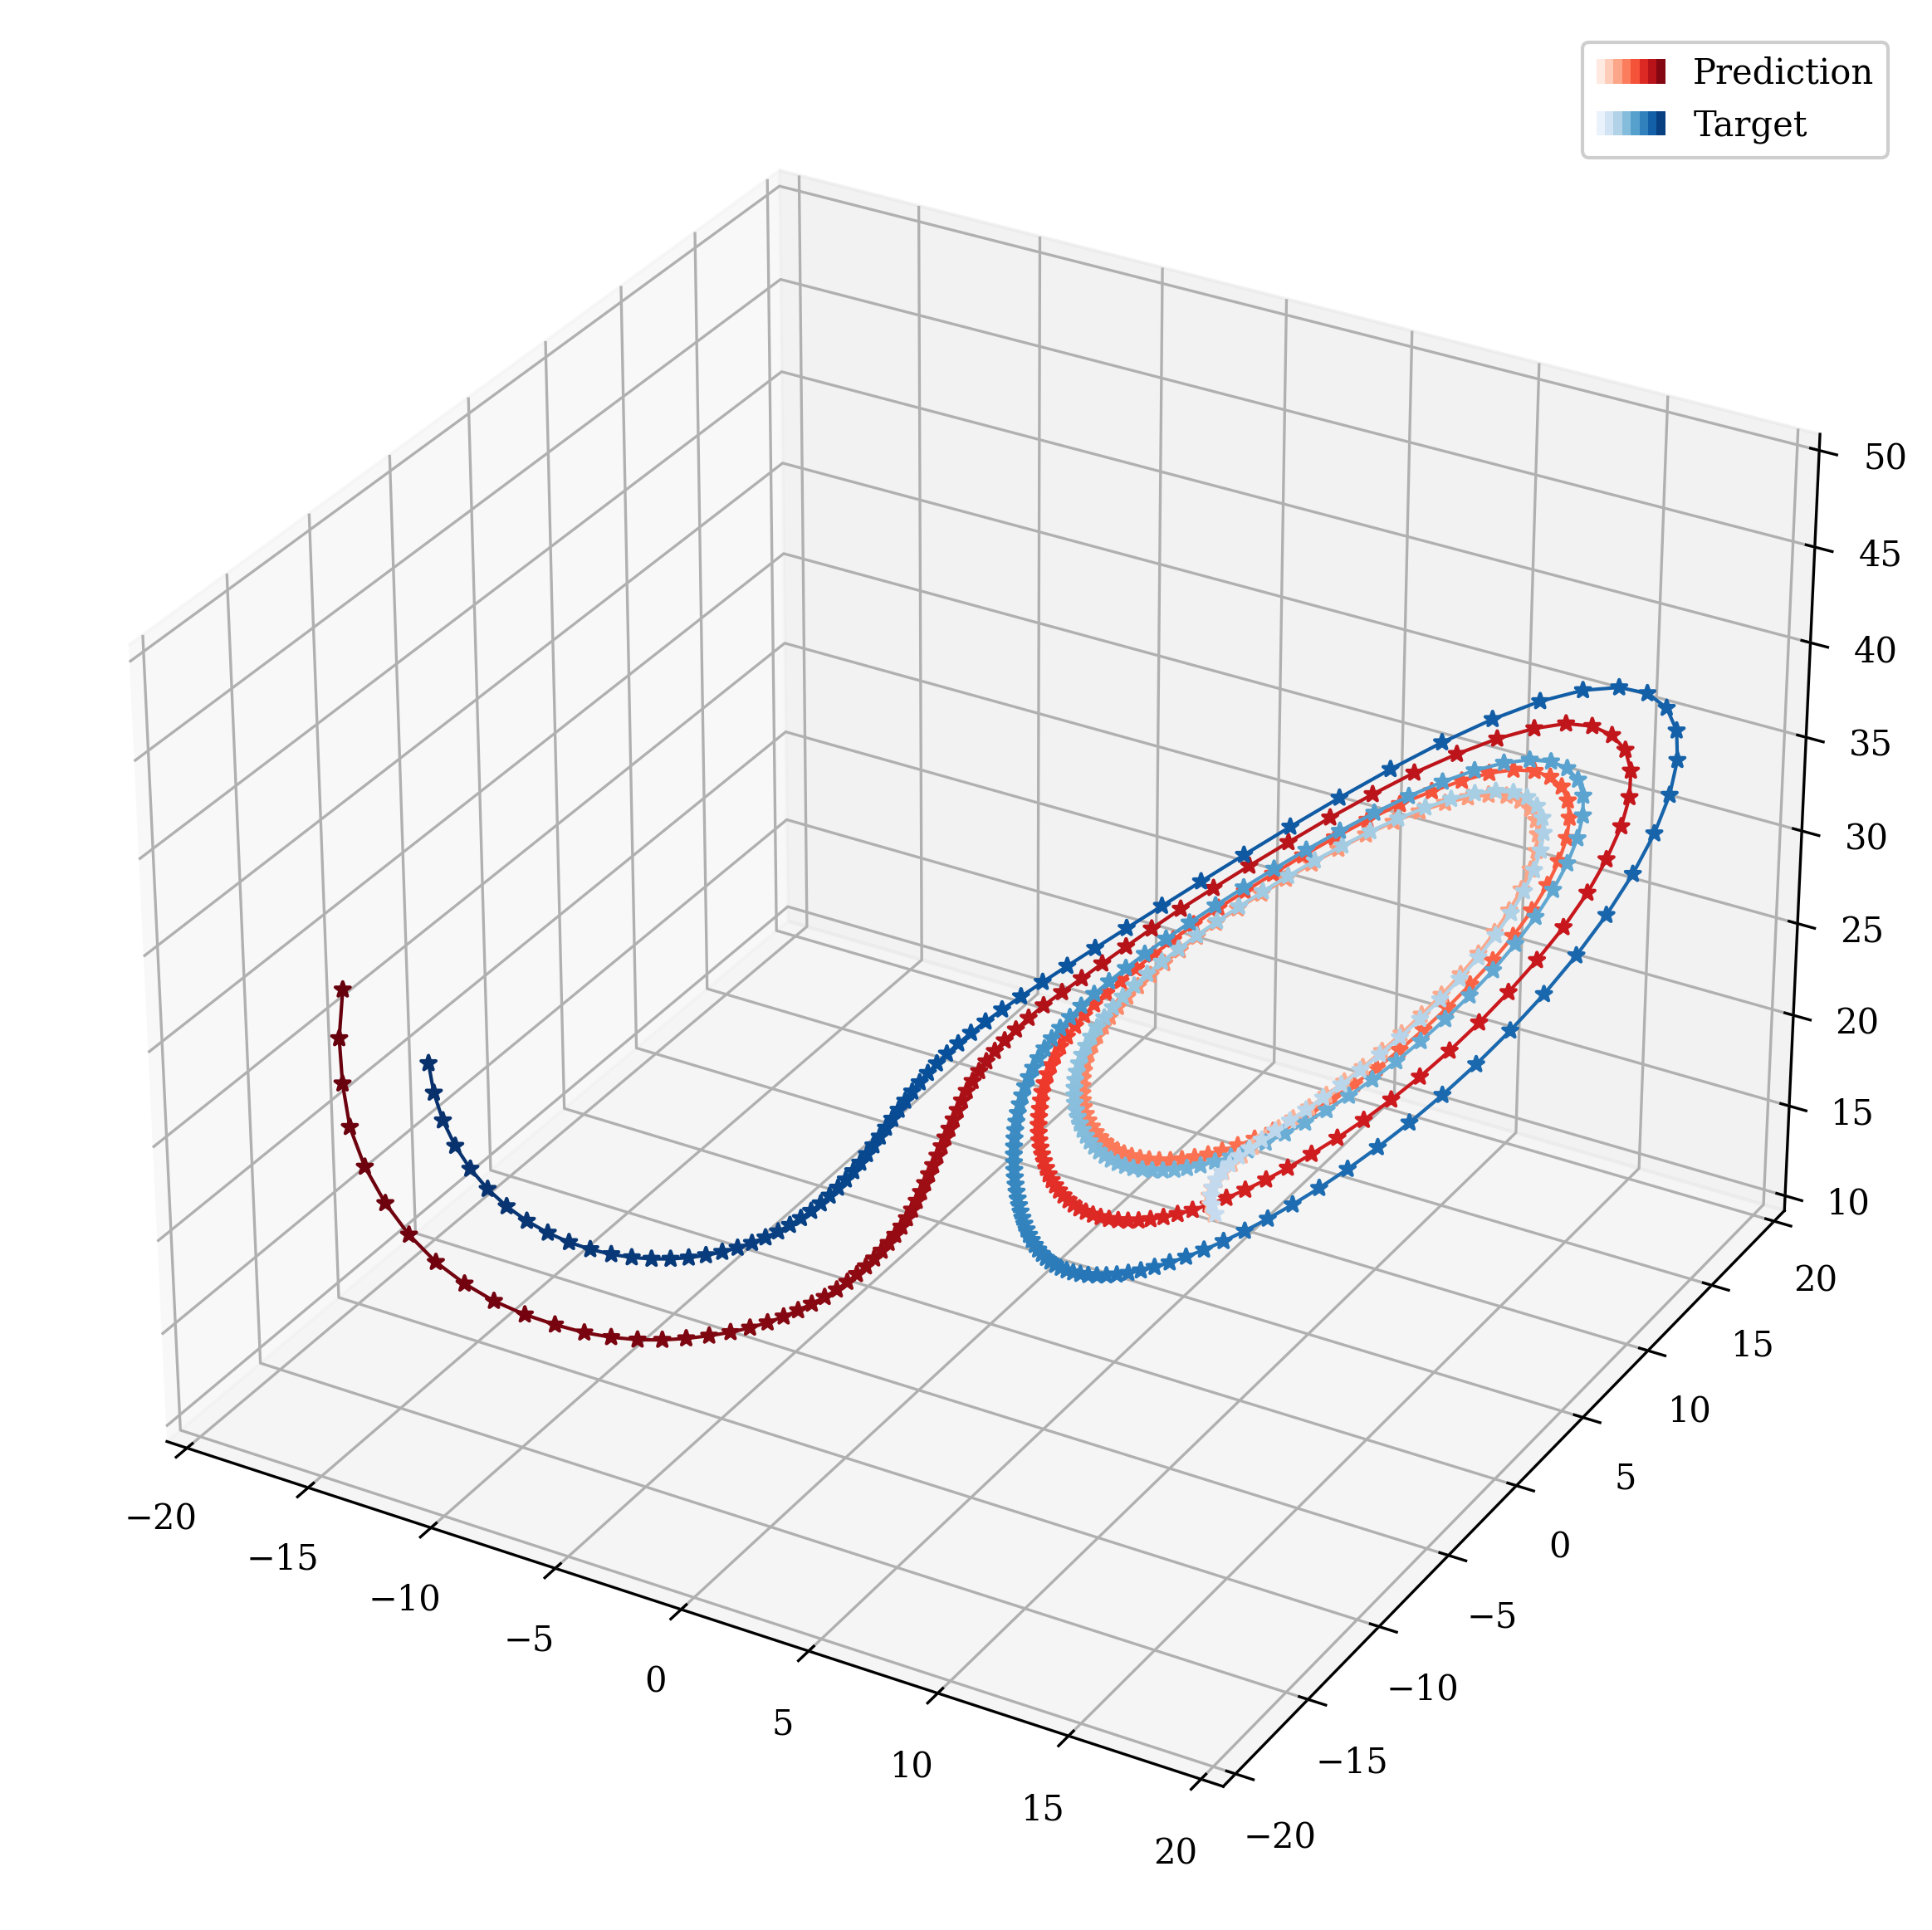

In [ ]:
from IPython.display import Image, display

for epoch in [1, 50, 100, 150, 200]:
  print('Validation prediction for epoch: {:d}'.format(epoch))
  file_path = './outputs/lorenz/ntrain2048_epochs200_batch32/viz/lorenzPred0_{:d}.png'.format(epoch)
  display(Image(file_path, width=300, height=300))